In [2]:
import datasets as ds
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import numpy as np
import nltk
import xgboost
nltk.download('wordnet')
nltk.download('omw-1.4')

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
MODELS_DIR

'/home/jovyan/projects/vector-nlp/models'

In [3]:
#ds.list_datasets()

In [4]:
app_dataset = ds.load_dataset('app_reviews',split='train')
app_df = app_dataset.to_pandas()
app_df['review_ls'] = app_df['review'].apply(lambda x: x.split(" "))
vocabulary = list(itertools.chain(*app_df['review_ls']))

Using custom data configuration default
Reusing dataset app_reviews (/home/jovyan/.cache/huggingface/datasets/app_reviews/default/0.0.0/20335b51b604b9bc04b7be253cd8445caa9ba93f15f39a4b0492b9e9102853de)


In [5]:
# X = app_df['review_lemma']
X = app_df['review']
y = app_df['star']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
# X_train = vect.fit_transform(X_train)
# X_test = vect.transform(X_test)
# X_val = vect.transform(X_val)

In [6]:
# from collections import Counter
# results = Counter(app_df.review_clean)
VOCAB_SIZE = len(vocabulary)
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

2022-03-07 02:37:35.148737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 02:37:35.148798: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 02:37:35.148820: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-07 02:37:35.149052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 02:37:35.223593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

In [7]:
np.array(encoder.get_vocabulary())

array(['', '[UNK]', 'the', ..., '00006', '00002323', '0000000000000'],
      dtype='<U474')

In [8]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [9]:
model.compile(loss = tf.keras.losses.mae, #mae stands for mean absolute error
              optimizer = tf.keras.optimizers.SGD(), #stochastic GD
              metrics = ['mae'])

In [10]:
history = model.fit(X_train, y_train, 
                    epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10
5402/5402 [==============================] - 338s 62ms/step - loss: 1.0068 - mae: 1.0068 - val_loss: 0.9348 - val_mae: 0.9348
Epoch 2/10
5402/5402 [==============================] - 382s 71ms/step - loss: 0.8625 - mae: 0.8625 - val_loss: 0.7610 - val_mae: 0.7610
Epoch 3/10
5402/5402 [==============================] - 355s 66ms/step - loss: 0.7354 - mae: 0.7354 - val_loss: 0.6927 - val_mae: 0.6927
Epoch 4/10
5402/5402 [==============================] - 358s 66ms/step - loss: 0.6880 - mae: 0.6880 - val_loss: 0.6869 - val_mae: 0.6869
Epoch 5/10
5402/5402 [==============================] - 333s 62ms/step - loss: 0.6641 - mae: 0.6641 - val_loss: 0.6921 - val_mae: 0.6921
Epoch 6/10
5402/5402 [==============================] - 316s 58ms/step - loss: 0.6459 - mae: 0.6459 - val_loss: 0.6742 - val_mae: 0.6742
Epoch 7/10
5402/5402 [==============================] - 327s 61ms/step - loss: 0.6319 - mae: 0.6319 - val_loss: 0.6469 - val_mae: 0.6469
Epoch 8/10
5402/5402 [===================

In [11]:
model.evaluate(X_val, y_val)  

1801/1801 [==============================] - 33s 18ms/step - loss: 0.6530 - mae: 0.6530


[0.65303635597229, 0.65303635597229]

In [12]:
y_pred = model.predict(X_val)

In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_val, y_pred)

0.653036

In [14]:
from sklearn.metrics import mean_squared_error
import math
print(mean_squared_error(y_val, y_pred))
print(math.sqrt(mean_squared_error(y_val, y_pred)))

1.2706896
1.1272486889176518


In [15]:
max(y_pred)

array([5.0499935], dtype=float32)

In [16]:
min(y_pred)

array([-0.15610754], dtype=float32)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          4385152   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,459,521
Trainable params: 4,459,521
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.save(os.path.join(MODELS_DIR,'2.1-LSTM_TFIDF'))

2022-03-07 03:35:23.959751: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM_TFIDF/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.1-LSTM_TFIDF/assets


In [19]:
new_model = tf.keras.models.load_model(os.path.join(MODELS_DIR,'2.1-LSTM_TFIDF'))
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          4385152   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,459,521
Trainable params: 4,459,521
Non-trainable params: 0
_________________________________________________________________


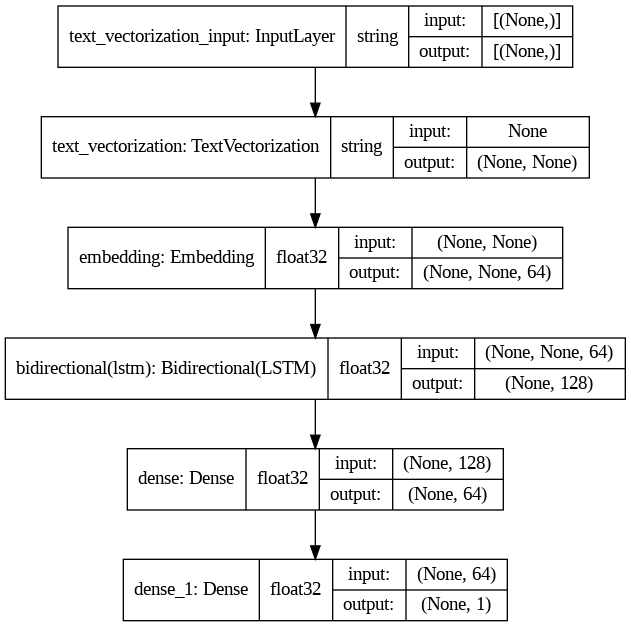

In [33]:
plot_model(model,os.path.join(IMAGES_DIR,'2.1-LSTM_MODEL_PLOT.png'),show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [45]:
eval_df = pd.merge(X_val, y_val, left_index=True, right_index=True)
eval_df['prediction'] = model.predict(eval_df.review).ravel()
eval_df['absolute_error'] = (eval_df['prediction'] - eval_df['star']).abs()
eval_df

,review,star,prediction,absolute_error
179623,Very good,5,5.017479,0.017479
236041,Well work. Need updates.,3,3.620065,0.620065
222198,Greatest application,5,5.024105,0.024105
190249,Free store Another,5,5.027055,0.027055
209847,Fabulous,3,5.033536,2.033536
...,...,...,...,...
72870,Uploading problem This mobile reporting applic...,1,3.854673,2.854673
286328,Epub format not picking I've used this app for...,3,1.417408,1.582592
140683,No persian languge It is good but there is per...,4,2.812909,1.187091
188443,Rajon Dhaka,5,4.491194,0.508806
